<a href="https://colab.research.google.com/github/ap0phasi/cerberusPy/blob/dev_s4layer/tests/example_cerberus_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

Then we import the necessary CerberusTS modules.

In [1]:
!git clone --branch dev_s4layer https://github.com/ap0phasi/cerberusPy.git

Cloning into 'cerberusPy'...
remote: Enumerating objects: 470, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 470 (delta 32), reused 30 (delta 15), pack-reused 411
Receiving objects: 100% (470/470), 22.00 MiB | 9.01 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [2]:
import os
os.chdir('cerberusPy')

In [3]:
!pip install pandas==2.0.3
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 29.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.7 MB/s eta 0:00:00


In [4]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True
CerberusConfig.processor_type = 'flatten'
CerberusConfig.foresight_residual = False

In [5]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [6]:
df = pd.read_csv(r"data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [7]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [8]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 64)

# Prepare the data
preparer.prepare_data()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
next(iter(preparer.dataloaders[0]))[0].device

device(type='cuda', index=0)

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [10]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=1024,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1024, 512, 256],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [256, 512],
                 out_channels = 128,
                 kernel_size = 3)

In [11]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 200, warmup_steps = 10)

Epoch [1/200], Loss: 0.008800975137307874
Epoch [2/200], Loss: 0.006101444191016709
Epoch [3/200], Loss: 0.004518143745403066
Epoch [4/200], Loss: 0.003359107424121219
Epoch [5/200], Loss: 0.00239680159124878
Epoch [6/200], Loss: 0.0015787420939669982
Epoch [7/200], Loss: 0.0009791381442393707
Epoch [8/200], Loss: 0.0007034788571230678
Epoch [9/200], Loss: 0.0005063643346513851
Epoch [10/200], Loss: 0.0003866873428878137
Epoch [11/200], Loss: 0.0003048785584899413
Epoch [12/200], Loss: 0.0002703076046003828
Epoch [13/200], Loss: 0.0002530131407708914
Epoch [14/200], Loss: 0.00025501217161472866
Epoch [15/200], Loss: 0.00025212262390519636
Epoch [16/200], Loss: 0.0014123571449588227
Epoch [17/200], Loss: 0.0004925870242864846
Epoch [18/200], Loss: 0.00017065486412111538
Epoch [19/200], Loss: 0.0001361168575033256
Epoch [20/200], Loss: 0.00011717102824672124
Epoch [21/200], Loss: 0.00011408446720901468
Epoch [22/200], Loss: 0.00011397318747348357
Epoch [23/200], Loss: 0.00051292923225300

## CerberusTS Training (No Foresight)

In [12]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=1024  ,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1024, 512, 256, 128],
                 dropout_rate = 0.0,
                 out_channels = 128,
                 kernel_size = 3)


In [13]:
#cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 100)

## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [14]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=1024,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [1024, 512, 256, 128],
                 dropout_rate = 0.0,
                 foresight = foresight,
                 eventualities = 10,
                 out_channels = 128,
                 kernel_size = 3)

In [15]:
cerberus_foresight = train_cerberus(cerberus_foresight, preparer.dataloaders, num_epochs = 200, warmup_steps = 10)

Epoch [1/200], Loss: 0.00131347682946922
Epoch [2/200], Loss: 0.0008048533563154003
Epoch [3/200], Loss: 0.0006226344464031366
Epoch [4/200], Loss: 0.00048807589002489187
Epoch [5/200], Loss: 0.0004098495457091302
Epoch [6/200], Loss: 0.00033660539314577296
Epoch [7/200], Loss: 0.00030452115074418984
Epoch [8/200], Loss: 0.00026233274676476005
Epoch [9/200], Loss: 0.00022959173188983196
Epoch [10/200], Loss: 0.00021127515938752892
Epoch [11/200], Loss: 0.00019163360980515892
Epoch [12/200], Loss: 0.00018679648812580557
Epoch [13/200], Loss: 0.00017317220257100262
Epoch [14/200], Loss: 0.00015643456965289154
Epoch [15/200], Loss: 0.000139957733199529
Epoch [16/200], Loss: 0.00013235135372324932
Epoch [17/200], Loss: 0.000131779783937849
Epoch [18/200], Loss: 0.00012035095409358255
Epoch [19/200], Loss: 0.00011106716116894775
Epoch [20/200], Loss: 0.00011402600099202701
Epoch [21/200], Loss: 0.00010341299216474254
Epoch [22/200], Loss: 0.00010117941778200292
Epoch [23/200], Loss: 0.00010

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

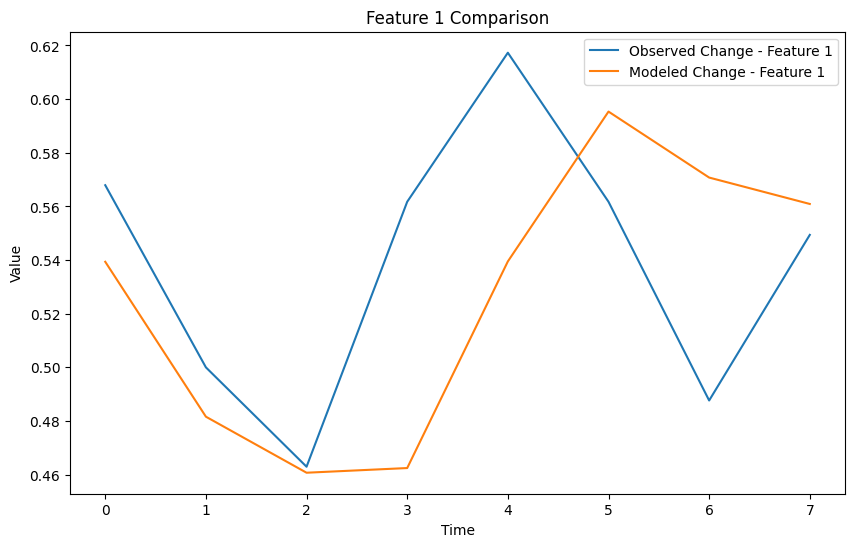

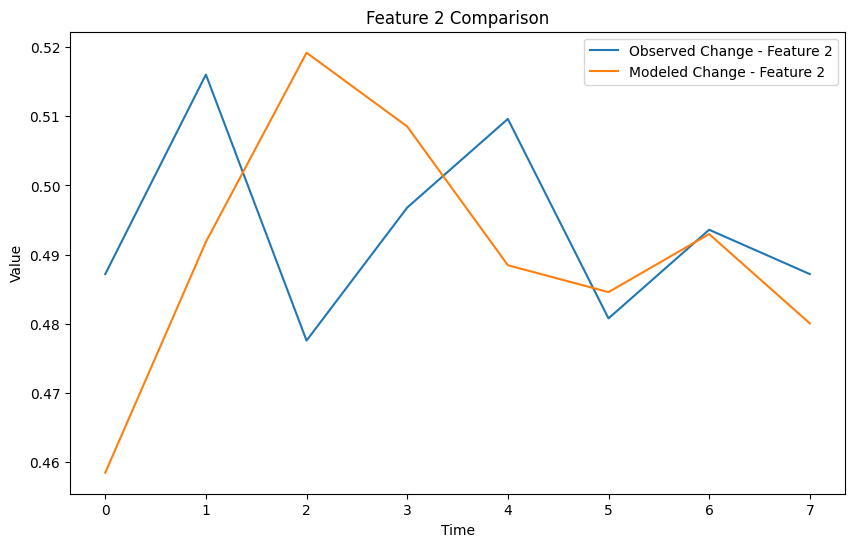

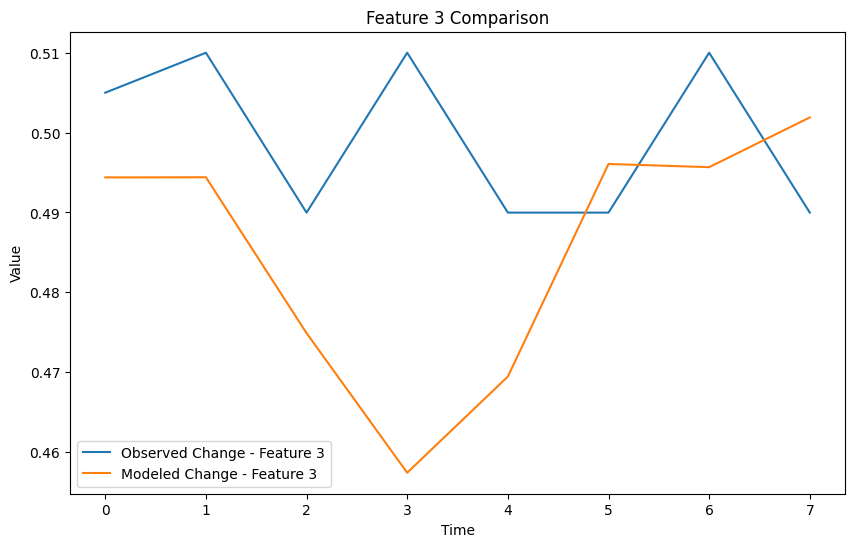

In [18]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_foresight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 4000
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

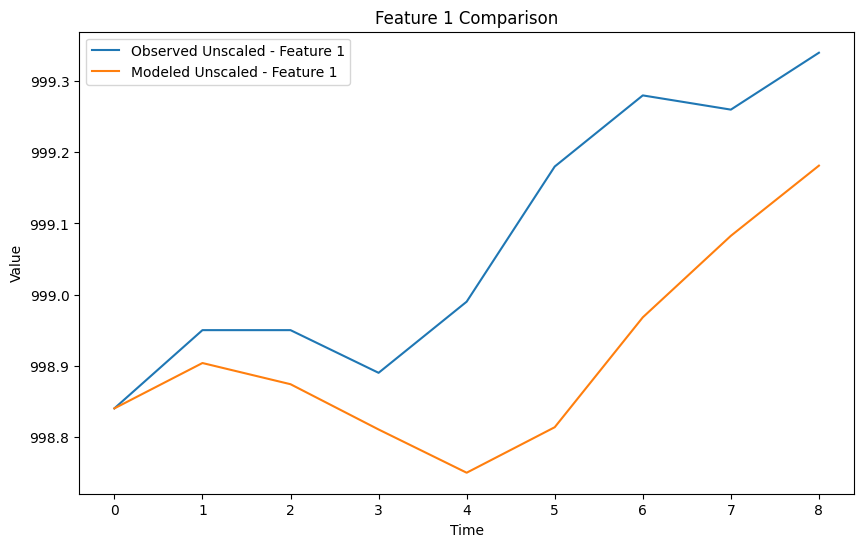

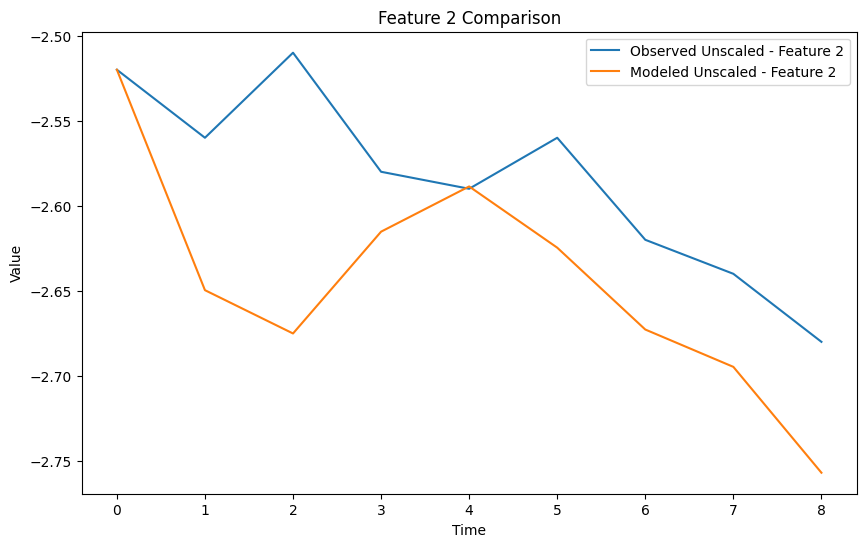

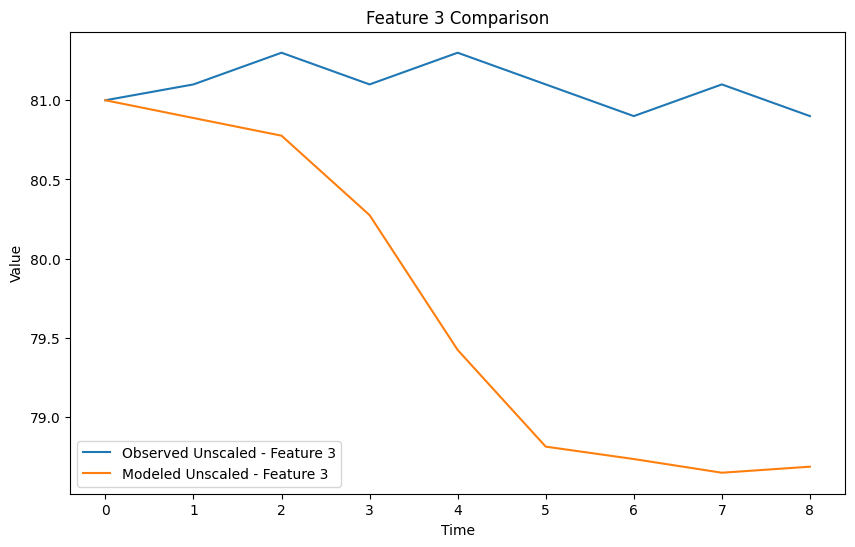

In [19]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)